# Dynamic Time Warping for Speech Recognition
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

In [1]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

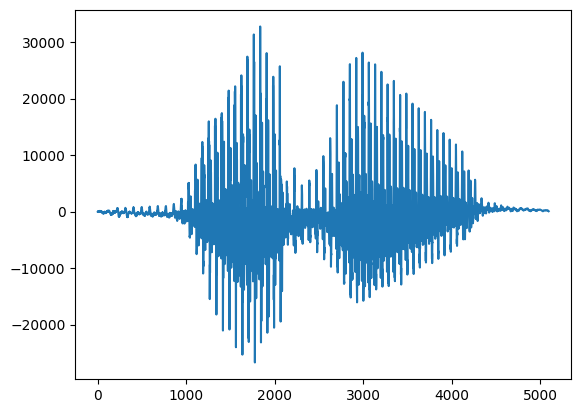

In [2]:
from scipy.io import wavfile

file_path = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

In [3]:
print(np.fft.ifft(np.log(np.abs(np.fft.fft(wav_data)))).shape)

(5098,)


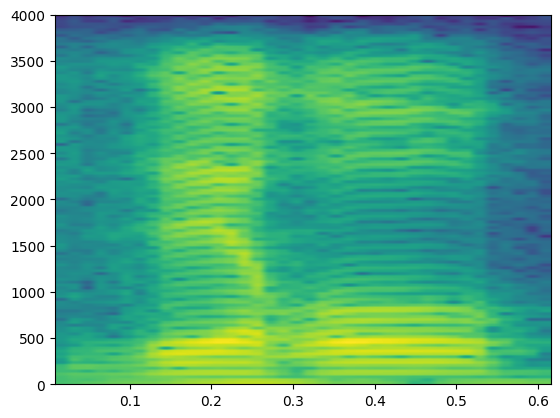

In [4]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

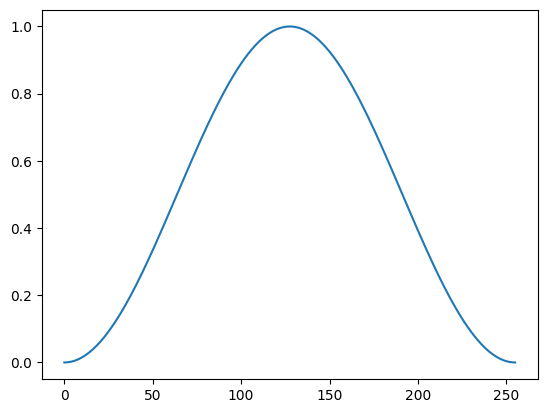

In [5]:
plt.plot(np.hanning(256))

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [6]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !
    cepstral_vectors = []
    data_length = len(wav_data)
    num_windows = (data_length - window_size) // window_shift + 1

    # Applying Hanning window
    window = np.hanning(window_size)

    for i in range(num_windows):
        start = i * window_shift
        end = start + window_size

        # Extracting current window of audio data
        windowed_data = wav_data[start:end] * window

        # Computing FFT and taking the real part
        fft_result = np.fft.fft(windowed_data)
        real_part = fft_result.real

        # Computing cepstral coefficients using inverse FFT
        cepstral_coefficients = np.fft.ifft(real_part)[:cepstral_order].real

        cepstral_vectors.append(cepstral_coefficients)

    cepstral_vectors = np.array(cepstral_vectors)
    
    return cepstral_vectors

In [7]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [8]:
5098 // 128 - 1

38

In [9]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $C (l_X \times l_Y)$ such that $C(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $D (l_X \times l_Y)$ such that $D(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $D(i,i)$ then $D(i+1,i), \dots D(l_X,i)$ and $D(i,i+1), D(i,i+2), \dots D(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```D```).

In [10]:
from scipy.spatial.distance import cdist

def time_alignment(X, Y, gamma):
    l_X = X.shape[0]
    l_Y = Y.shape[0]

    # Calculation of the similarity matrix
    C = cdist(X, Y, metric='euclidean')

    # Initialization of the cumulative distance matrix
    D = np.zeros((l_X, l_Y))
    D[0, 0] = C[0, 0]

    # Calculation of the matrix of cumulative distances
    for i in range(1, l_X):
        D[i, 0] = D[i-1, 0] + gamma * C[i, 0]

    for j in range(1, l_Y):
        D[0, j] = D[0, j-1] + gamma * C[0, j]

    for i in range(1, l_X):
        for j in range(1, l_Y):
            D[i, j] = min(D[i-1, j-1], D[i-1, j], D[i, j-1]) + gamma * C[i, j]

    # Backtracking
    M = []
    i = l_X - 1
    j = l_Y - 1

    while i > 0 and j > 0:
        M.insert(0, [i, j])

        if D[i-1, j-1] <= D[i-1, j] and D[i-1, j-1] <= D[i, j-1]:
            i -= 1
            j -= 1
        elif D[i-1, j] <= D[i-1, j-1] and D[i-1, j] <= D[i, j-1]:
            i -= 1
        else:
            j -= 1

    if i > 0:
        for k in range(i, 0, -1):
            M.insert(0, [k, 0])

    if j > 0:
        for k in range(j, 0, -1):
            M.insert(0, [0, k])

    M.insert(0, [0, 0])

    return D, M, C

In [11]:
# Example of time alignment
file_path_1 = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

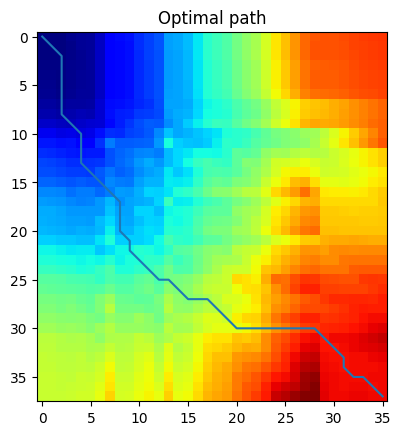

Cost of the optimal path: [[ 7.5092  7.195   3.4294 ... 21.8495 13.8643 13.7968]
 [ 6.0328  5.6975  1.9976 ... 20.3734 12.3938 12.3245]
 [ 5.0093  4.6967  2.1903 ... 19.1519 11.3366 11.1798]
 ...
 [12.7117 13.1373 16.8496 ...  1.7983  6.524   6.5113]
 [ 2.4454  2.9331  6.5794 ... 11.9284  4.0108  3.8775]
 [ 0.5751  0.8047  4.2154 ... 14.4195  6.5628  6.4075]]


In [12]:
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0])
plt.show()
print("Cost of the optimal path:", distance)

### Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

We take as reference the sequence number 0.

In [13]:
reference_repetition = 1  # Choose the repetition of the reference sequence
reference_number = 0  # Choose the number of the reference sequence

# Define the file paths of the reference sequence
reference_file_path = f"./SIG/SIG_Rep_{reference_repetition}_Number_{reference_number}.wav"
sample_rate_ref, wav_data_ref = wavfile.read(reference_file_path)

# Perform feature extraction on the reference sequence
cepstral_vectors_ref = feature_extraction(wav_data_ref, window_size, window_shift, cepstral_order)

In [14]:
# Perform time alignment and distance calculation for each target sequence
closest_distance = float('inf')  # Initialize with a large value
closest_number = None
closest_repetition = None

for repetition in range(1, 13):
    for number in range(10):
        # Skip the reference sequence
        if repetition == reference_repetition and number == reference_number:
            continue

        # Define the file path of the target sequence
        target_file_path = f"./SIG/SIG_Rep_{repetition}_Number_{number}.wav"
        sample_rate_target, wav_data_target = wavfile.read(target_file_path)

        # Perform feature extraction on the target sequence
        cepstral_vectors_target = feature_extraction(wav_data_target, window_size, window_shift, cepstral_order)

        # Perform time alignment
        D, M, distance = time_alignment(cepstral_vectors_ref, cepstral_vectors_target, gamma=2)

        # Calculate the distance between the reference and target sequences
        last_element = M[-1]
        distance_value = distance[last_element[0], last_element[1]]

        # Update the closest distance if necessary
        if distance_value < closest_distance:
            closest_distance = distance_value
            closest_number = number
            closest_repetition = repetition

print(f"The closest match to the reference sequence is Number {closest_number} in Repetition {closest_repetition}.")
print(f"Distance: {closest_distance}")

The closest match to the reference sequence is Number 1 in Repetition 1.
Distance: 2.4029983800533534


## Evaluation of Speech Recognition

The goal of this part is to implement an evaluation strategy in order to check how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknow signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. Ideally, we would need to rotate the reference/unknown sets to perform cross-validation - but we can work with a random choice of only one reference for each number to simplify the setup. 
To do so, write a function ```classification```. For example, you can use the following formalism : 

```[confusion, accuracy] = classification(vectors, gamma)```

- ```vectors``` contains all the cepstral vectors for the signals in the chosen dataset. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.


- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate (averaged over cross-validation experiments if used).

Questions: 
- Evaluate the speech recognition performance on the data ```SIG```, and then on the data ```SIG2```. Visualize the confusion matrices ? 
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Try to interpret the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose (shortly) possible solutions to these problems.